# Random Forest
Total dataset size: 127 samples <br>
Training set: 95 samples <br>
Testing set: 32 samples

Features used:
- LTA precipitation (mmpa)
- LTA WD (days)
- LTA PET (mm)
- Aridity idx
- LTA NDVI idx
- LTA soil moisture - 10cm (kgm-2)
- Aquifer group (cat.)
- Soil group (cat.)
- Landcover (cat.)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates

# read file (data + coordinates)
file = pd.read_csv('poc.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa'] < 800]

# extract data only for one-hot encoding
data = file.drop(columns=['Lat', 'Long', 'ID', 'Landcover', 'SM10_kgm2', 'LTA_WD_days'])
data

,Recharge_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Aquifer_group,Soil_group,Landcover_ext,DEM,SM10_m3m3
0,253.0,1234.743356,1265.000000,0.977426,0.548899,Basement,LX,130,360,0.317942
1,22.0,555.876675,1386.030028,0.403442,0.417538,Basement,AC,30,1039,0.210401
2,245.0,1376.716688,1337.440024,1.029575,0.687945,Basement,NT,30,1125,0.312940
3,185.0,518.196676,1590.610029,0.326188,0.268559,Sedimentary,LP,200,1657,0.229384
4,120.0,1344.580024,1298.693353,1.038857,0.593882,Sedimentary,NT,30,26,0.330358
...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,1356.070025,0.486649,0.403724,Sedimentary,LP,30,1376,0.323871
130,80.0,816.720013,1266.233355,0.648767,0.479056,Basement,CM,130,1382,0.227937
131,8.0,510.140009,1922.536704,0.265403,0.327490,Unconsolidated,GL,14,28,0.194245
132,160.0,1215.073356,1149.026683,1.058098,0.447078,Sedimentary,LP,20,2482,0.279276


In [2]:
# encode categorical variables
labelencoder = LabelEncoder()
data['Aquifer_group_cat'] = labelencoder.fit_transform(data['Aquifer_group'])
data['Soil_group_cat'] = labelencoder.fit_transform(data['Soil_group'])

# remove categorical variables
data = data.drop('Aquifer_group', axis = 1)
data = data.drop('Soil_group', axis = 1)

data

,Recharge_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Landcover_ext,DEM,SM10_m3m3,Aquifer_group_cat,Soil_group_cat
0,253.0,1234.743356,1265.000000,0.977426,0.548899,130,360,0.317942,0,12
1,22.0,555.876675,1386.030028,0.403442,0.417538,30,1039,0.210401,0,0
2,245.0,1376.716688,1337.440024,1.029575,0.687945,30,1125,0.312940,0,13
3,185.0,518.196676,1590.610029,0.326188,0.268559,200,1657,0.229384,1,10
4,120.0,1344.580024,1298.693353,1.038857,0.593882,30,26,0.330358,1,13
...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,1356.070025,0.486649,0.403724,30,1376,0.323871,1,10
130,80.0,816.720013,1266.233355,0.648767,0.479056,130,1382,0.227937,0,4
131,8.0,510.140009,1922.536704,0.265403,0.327490,14,28,0.194245,2,8
132,160.0,1215.073356,1149.026683,1.058098,0.447078,20,2482,0.279276,1,10


Text(0, 0.5, 'Number of observations')

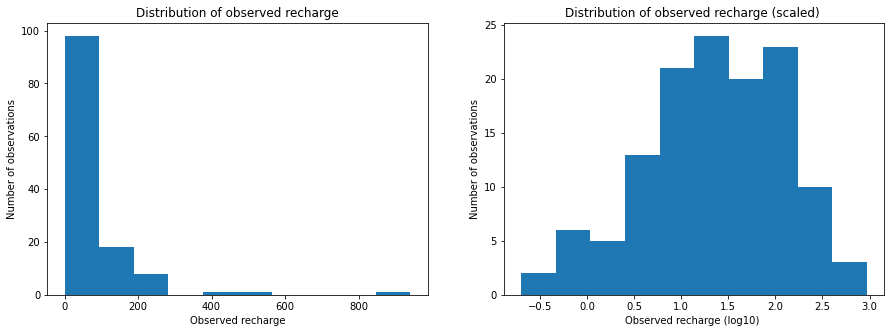

In [3]:
n_bins = 10

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
# We can set the number of bins with the `bins` kwarg
axs[0].hist(data['Recharge_mmpa'], bins=n_bins)
axs[0].set_title('Distribution of observed recharge')
axs[0].set_xlabel('Observed recharge')
axs[0].set_ylabel('Number of observations')

axs[1].hist(np.log10(data['Recharge_mmpa']), bins=n_bins)
axs[1].set_title('Distribution of observed recharge (scaled) ')
axs[1].set_xlabel('Observed recharge (log10) ')
axs[1].set_ylabel('Number of observations')

In [4]:
# Labels are the values we want to predict
#labels = data['Recharge_mmpa']
labels = np.log10(data['Recharge_mmpa'])
# Remove the labels from the features
data = data.drop('Recharge_mmpa', axis = 1)
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

 # Experiment 1: 100 runs for reliable importance measure

In [9]:
# collect all importances, R2 and oob values to calculate the average over 100 models
importances = []
train_r2=[]
test_r2=[]
oobs=[]
train_r2_untransf=[]
test_r2_untransf=[]
# find the best model based on the lowest RMSE
best_model = None
best_r2 = 0
best_importances = None
best_train_features, best_test_features, best_train_labels, best_test_labels = None, None, None, None
best_rmse = 300
# find the worst model based on the highest RMSE
worst_model = None
worst_r2 = 100
worst_train_features, worst_test_features, worst_train_labels, worst_test_labels = None, None, None, None
worst_rmse = 0

# run model 100 times
for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)    
    # Instantiate models with 2000 decision trees
    rf = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True)
    
    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    train_predictions = rf.predict(train_features)
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    print(f'Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = metrics.mean_squared_error(10**test_labels, 10**predictions, squared=False)
    print(f"current rmse {current_rmse}")
    if current_r2>best_r2:
        best_rmse = current_rmse
        best_r2 = current_r2
        best_model = rf
        best_importances = rf.feature_importances_
        best_train_features, best_test_features, best_train_labels, best_test_labels = train_features, test_features, train_labels, test_labels
    
    if current_r2<worst_r2:
        worst_r2 = current_r2
        worst_rmse = current_rmse
        worst_model = rf
        worst_train_features, worst_test_features, worst_train_labels, worst_test_labels = train_features, test_features, train_labels, test_labels
    importances.append(rf.feature_importances_)

Out-of-bag score estimate: 0.654; Train R-2: 0.951, Test R-2:  0.59
current rmse 66.00190879215444
Out-of-bag score estimate: 0.632; Train R-2: 0.942, Test R-2: 0.647
current rmse 85.16104464093922
Out-of-bag score estimate: 0.683; Train R-2:  0.95, Test R-2: 0.473
current rmse 67.6814158767537
Out-of-bag score estimate: 0.635; Train R-2: 0.944, Test R-2: 0.622
current rmse 71.49553506672407
Out-of-bag score estimate: 0.542; Train R-2: 0.932, Test R-2: 0.785
current rmse 153.01828177208708
Out-of-bag score estimate: 0.688; Train R-2: 0.958, Test R-2: 0.582
current rmse 126.51021927997084
Out-of-bag score estimate: 0.686; Train R-2: 0.954, Test R-2: 0.509
current rmse 66.1598204699491
Out-of-bag score estimate: 0.646; Train R-2:  0.95, Test R-2: 0.674
current rmse 133.99634527362323
Out-of-bag score estimate:  0.71; Train R-2: 0.958, Test R-2: 0.434
current rmse 46.52463346474396
Out-of-bag score estimate:  0.62; Train R-2: 0.946, Test R-2: 0.658
current rmse 137.57332065414073
Out-of-b

Out-of-bag score estimate: 0.664; Train R-2: 0.953, Test R-2: 0.543
current rmse 82.01017842810892
Out-of-bag score estimate: 0.628; Train R-2: 0.944, Test R-2: 0.664
current rmse 55.75511133749288
Out-of-bag score estimate:  0.65; Train R-2:  0.95, Test R-2: 0.655
current rmse 73.35022071808173
Out-of-bag score estimate:  0.57; Train R-2: 0.936, Test R-2: 0.689
current rmse 161.49354389687034
Out-of-bag score estimate: 0.677; Train R-2:  0.95, Test R-2: 0.528
current rmse 38.81720271408214
Out-of-bag score estimate: 0.646; Train R-2: 0.949, Test R-2: 0.575
current rmse 53.02938705576845
Out-of-bag score estimate: 0.625; Train R-2: 0.943, Test R-2: 0.641
current rmse 155.01820540703082
Out-of-bag score estimate: 0.635; Train R-2: 0.943, Test R-2: 0.666
current rmse 34.654926796993024
Out-of-bag score estimate: 0.615; Train R-2: 0.943, Test R-2: 0.733
current rmse 59.0503915059562
Out-of-bag score estimate: 0.627; Train R-2: 0.948, Test R-2: 0.674
current rmse 91.10120833605932
Out-of-b

In [10]:
best_predictions = best_model.predict(best_test_features)
# Use the forest's predict method on the training data
best_train_predictions = best_model.predict(best_train_features)

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels, 10**best_train_predictions, squared=False)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {metrics.mean_squared_error(10**best_test_labels, 10**best_predictions, squared=False)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

+++ METRICS ON LOG-TRANSFORMED VALUES +++
Max R2 train: 0.9607552425955832
Min R2 train: 0.9315557127308651
Mean R2 train: 0.9476159920214124
Best RMSE train: 65.11459327800488

Max oob: 0.7251724261861399
Min oob: 0.5418386928637692
Mean oob: 0.6445374407669405

Max R2 test: 0.7900609737939468
Min R2 test: 0.28195214285634373
Mean R2 test: 0.6252171075711325
Best RMSE test: 65.41797779146532

+++ METRICS ON BACK TRANSFORMED VALUES +++
Max R2 train: 0.8865300860397527
Min R2 train: 0.6989171460842352
Mean R2 train: 0.7950487204857514

Max R2 test: 0.5992423705136201
Min R2 test: -0.7433304854536544
Mean R2 test: 0.2453852274361633


In [11]:
print("+++ Best model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Best R2 train: ', best_model.score(best_train_features, best_train_labels))
print(f'Best R2 test:  {best_model.score(best_test_features, best_test_labels)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels, 10**best_train_predictions, squared=False)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels, 10**best_train_predictions)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels, 10**best_predictions)}")

+++ Best model metrics +++

--- log transformed ---
Out-of-bag R-2 score estimate: 0.571
Best R2 train:  0.9354616436278494
Best R2 test:  0.7900609737939468

--- back transformed ---
Best RMSE train: 65.11459327800488
Best RMSE test: 65.41797779146532
Best R2 train: 0.7173203626721435
Best R2 test: 0.4731255105190393


In [12]:
worst_predictions = worst_model.predict(worst_test_features)
# Use the forest's predict method on the training data
worst_train_predictions = worst_model.predict(worst_train_features)

print("+++ Worst model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {worst_model.oob_score_:>5.3}')
print('worst R2 train: ', worst_model.score(best_train_features, worst_train_labels))
print(f'worst R2 test:  {worst_model.score(best_test_features, worst_test_labels)}\n')
print("--- back transformed ---")
print(f'worst RMSE train: {metrics.mean_squared_error(10**worst_train_labels, 10**worst_train_predictions, squared=False)}')
print(f"worst RMSE test: {worst_rmse}")
print(f"worst R2 train: {metrics.r2_score(10**worst_train_labels, 10**worst_train_predictions)}")
print(f"worst R2 test: {metrics.r2_score(10**worst_test_labels, 10**worst_predictions)}")

+++ Worst model metrics +++

--- log transformed ---
Out-of-bag R-2 score estimate: 0.724
worst R2 train:  -0.7377512439279912
worst R2 test:  -1.3601356371227706

--- back transformed ---
worst RMSE train: 54.601058488553036
worst RMSE test: 80.83048693233832
worst R2 train: 0.8217352958599174
worst R2 test: -0.7433304854536544


In [13]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean feature importance
Variable: LTA_P_mmpa           Importance: 0.23
Variable: Aridity              Importance: 0.19
Variable: SM10_m3m3            Importance: 0.19
Variable: NDVI                 Importance: 0.14
Variable: LTA_PET_mm           Importance: 0.08
Variable: Landcover_ext        Importance: 0.06
Variable: DEM                  Importance: 0.05
Variable: Soil_group_cat       Importance: 0.04
Variable: Aquifer_group_cat    Importance: 0.02


In [14]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Best performing model: feature importance
Variable: LTA_P_mmpa           Importance: 0.22
Variable: Aridity              Importance: 0.2
Variable: SM10_m3m3            Importance: 0.18
Variable: NDVI                 Importance: 0.14
Variable: LTA_PET_mm           Importance: 0.08
Variable: Landcover_ext        Importance: 0.07
Variable: DEM                  Importance: 0.05
Variable: Soil_group_cat       Importance: 0.04
Variable: Aquifer_group_cat    Importance: 0.02


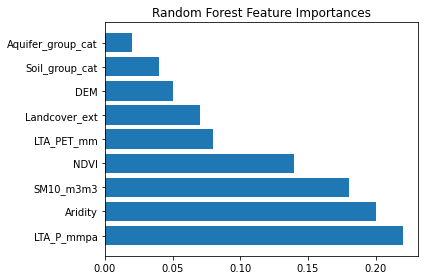

In [15]:
feature_names = [f[0] for f in feature_importances]
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, [f[1] for f in feature_importances])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

## Discourse: MANUAL FEATURE IMPORTANCE ASSESSMENT
code from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

#### Permutation importance

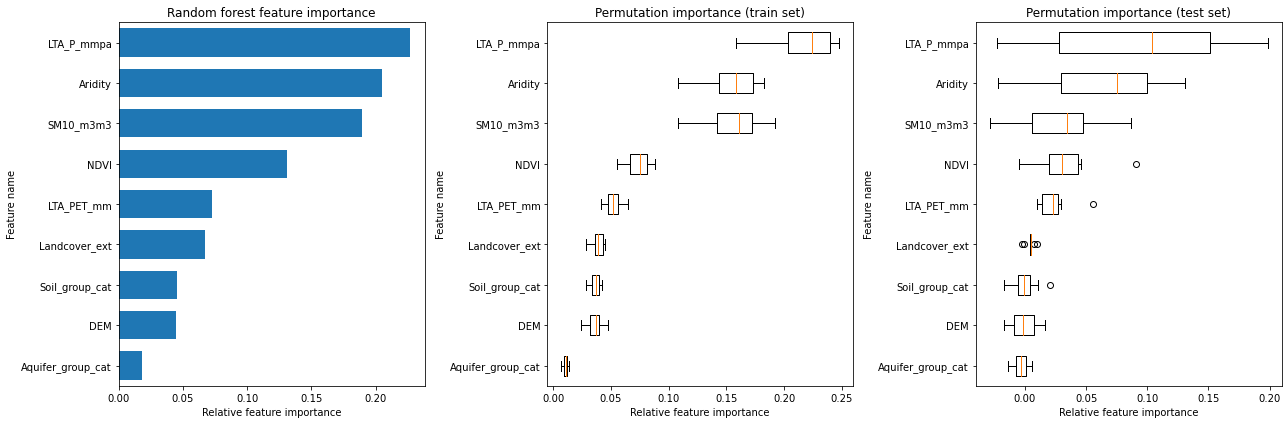

In [11]:
from sklearn.inspection import permutation_importance
feature_names = data.columns

# permutation importance on training set
result_train = permutation_importance(best_model, best_train_features, best_train_labels, n_repeats=30,
                                random_state=42)
perm_sorted_idx = result_train.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(best_model.feature_importances_)
tree_indices = np.arange(0, len(best_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.barh(tree_indices,
         best_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_title('Random forest feature importance')
ax1.set_ylabel('Feature name')
ax1.set_xlabel('Relative feature importance')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(best_model.feature_importances_)))
ax2.boxplot(result_train.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax2.set_title('Permutation importance (train set)')
ax2.set_ylabel('Feature name')
ax2.set_xlabel('Relative feature importance')

# permutation importance on test set
result_test = permutation_importance(best_model, best_test_features, best_test_labels, n_repeats=10,
                                random_state=42)

perm_sorted_idx = result_test.importances_mean.argsort()
ax3.boxplot(result_test.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax3.set_title('Permutation importance (test set)')
ax3.set_ylabel('Feature name')
ax3.set_xlabel('Relative feature importance')


fig.tight_layout()
plt.show()

#### Spearman rank based hierarchy clustering

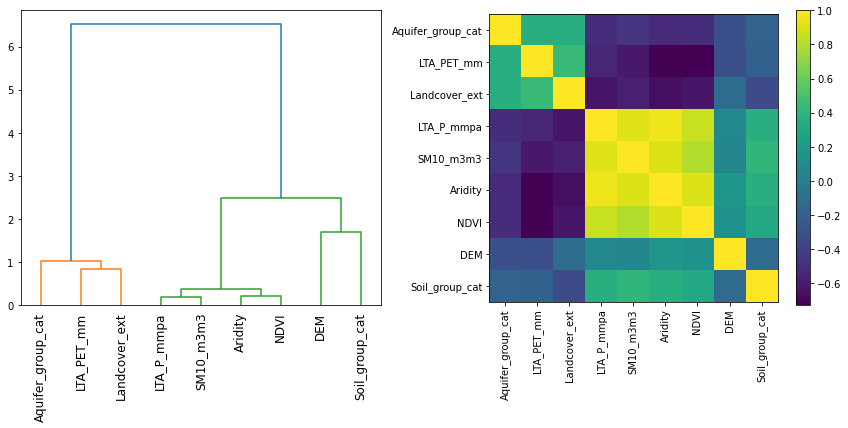

In [12]:
# handle multicollinearity
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
corr = spearmanr(features).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
fig.colorbar(im)
plt.show()

In [13]:
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
print(cluster_id_to_feature_ids)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = best_train_features[:, selected_features]
X_test_sel = best_test_features[:, selected_features]

clf_sel = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
clf_sel.fit(X_train_sel, best_train_labels)
print("Accuracy on train data with features removed: {:.2f}".format(
      clf_sel.score(X_train_sel, best_train_labels)))
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, best_test_labels)))

defaultdict(<class 'list'>, {3: [0, 2, 3, 6], 1: [1, 4], 4: [5], 2: [7], 5: [8]})
Accuracy on train data with features removed: 0.92
Accuracy on test data with features removed: 0.67


### add variables
first uncorrelated, then correlated 

under fixed random state

In [14]:
X_train, X_test = best_train_features[:,[0]], best_test_features[:,[0]]
rf_precip = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 1
train_r2 = rf_precip.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[adj R2] Accuracy on train data with precipitation only: {:.2f}".format(train_adj_r2))
print("[adj R2] Accuracy on test data with precipitation only: {:.2f}".format(test_adj_r2))

[adj R2] Accuracy on train data with precipitation only: 0.92
[adj R2] Accuracy on test data with precipitation only: 0.48


In [15]:
X_train, X_test = best_train_features[:,[0,1]], best_test_features[:,[0,1]]
rf_precip_pet = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 2
train_r2 = rf_precip_pet.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet only: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet only: {:.2f}".format(test_adj_r2))
print('PET improves!')

[Adj R2] Accuracy on train data with precipitation + pet only: 0.93
[Adj R2] Accuracy on test data with precipitation + pet only: 0.66
PET improves!


In [16]:
X_train, X_test = best_train_features[:,[0,1,5]], best_test_features[:,[0,1,5]]
rf_precip_pet_dem = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_dem.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_dem.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_dem.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + dem only: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + dem only: {:.2f}".format(test_adj_r2))
print('DEM steady!')

[Adj R2] Accuracy on train data with precipitation + pet + dem only: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + dem only: 0.66
DEM steady!


In [17]:
X_train, X_test = best_train_features[:,[0,1,7]], best_test_features[:,[0,1,7]]
rf_precip_pet_sm_ai_ndvi_aq = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi_aq.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sm_ai_ndvi_aq.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi_aq.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)

print("[Adj R2] Accuracy on train data with precipitation + pet + aq: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aq: {:.2f}".format(test_adj_r2))
print('Aquifer group doesn\'t improve!')

[Adj R2] Accuracy on train data with precipitation + pet + aq: 0.92
[Adj R2] Accuracy on test data with precipitation + pet + aq: 0.67
Aquifer group doesn't improve!


In [18]:
X_train, X_test = best_train_features[:,[0,1,8]], best_test_features[:,[0,1,8]]
rf_precip_pet_sg = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sg.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sg.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sg.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + soil group: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + soil group: {:.2f}".format(test_adj_r2))
print('Soil group doesn\'t improve!')

[Adj R2] Accuracy on train data with precipitation + pet + soil group: 0.92
[Adj R2] Accuracy on test data with precipitation + pet + soil group: 0.64
Soil group doesn't improve!


In [19]:
X_train, X_test = best_train_features[:,[0,1,2]], best_test_features[:,[0,1,2]]
rf_precip_pet_sm_ai = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sm_ai.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity: {:.2f}".format(test_adj_r2))
print('Aridity improves!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + aridity: 0.63
Aridity improves!


In [20]:
X_train, X_test = best_train_features[:,[0,1,2,3]], best_test_features[:,[0,1,2,3]]
rf_precip_pet_sm_ai_ndvi = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 4
train_r2 = rf_precip_pet_sm_ai_ndvi.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi: {:.2f}".format(test_adj_r2))
print('NDVI improves!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi: 0.94
[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi: 0.68
NDVI improves!


In [21]:
X_train, X_test = best_train_features[:,[0,1,2,3,6]], best_test_features[:,[0,1,2,3,6]]
rf_precip_pet_sm = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 5
train_r2 = rf_precip_pet_sm.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + soil moisture: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + soil moisture: {:.2f}".format(test_adj_r2))
print('Soil moisture steady!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + soil moisture: 0.94
[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + soil moisture: 0.69
Soil moisture steady!


In [22]:
X_train, X_test = best_train_features[:,[0,1,2,3,4,6]], best_test_features[:,[0,1,2,3,4,6]]
rf_precip_pet_lc = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_lc.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 6
train_r2 = rf_precip_pet_lc.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_lc.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + sm + lc: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + + aridity + ndvi + sm + lc: {:.2f}".format(test_adj_r2))
print('Landcover steady!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + sm + lc: 0.94
[Adj R2] Accuracy on test data with precipitation + pet + + aridity + ndvi + sm + lc: 0.66
Landcover steady!


In [23]:
X_train, X_test = best_train_features, best_test_features
rf_all = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_all.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 9
train_r2 = rf_all.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_all.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)

print("[Adj R2] Accuracy on train data with all predictors: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with all predictors: {:.2f}".format(test_adj_r2))

[Adj R2] Accuracy on train data with all predictors: 0.93
[Adj R2] Accuracy on test data with all predictors: 0.62


### First run: statistics of the best model

In [16]:
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Score: ', best_model.score(best_train_features, best_train_labels))
print('Score: ', best_model.score(best_test_features, best_test_labels))

Out-of-bag R-2 score estimate: 0.571
Score:  0.9354616436278494
Score:  0.7900609737939468


In [17]:
# training set metrics
print('=== Prediction of training set - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_train_labels, best_train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_train_labels, best_train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_train_labels, best_train_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_train_labels, best_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_train_labels, best_train_predictions))
print('Max Error:', metrics.max_error(best_train_labels, best_train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_train_labels, best_train_predictions))
print('R^2:', metrics.r2_score(best_train_labels, best_train_predictions))

=== Prediction of training set - best performing model ===
Mean Absolute Error (MAE): 0.1481884654515235
Mean Squared Error (MSE): 0.035331119371137955
Root Mean Squared Error (RMSE): 0.18796573988665582
Mean Absolute Percentage Error (MAPE): 590547006078.2382
Explained Variance Score: 0.935502200175809
Max Error: 0.48310479742544965
Median Absolute Error: 0.12113093183883145
R^2: 0.9354616436278494


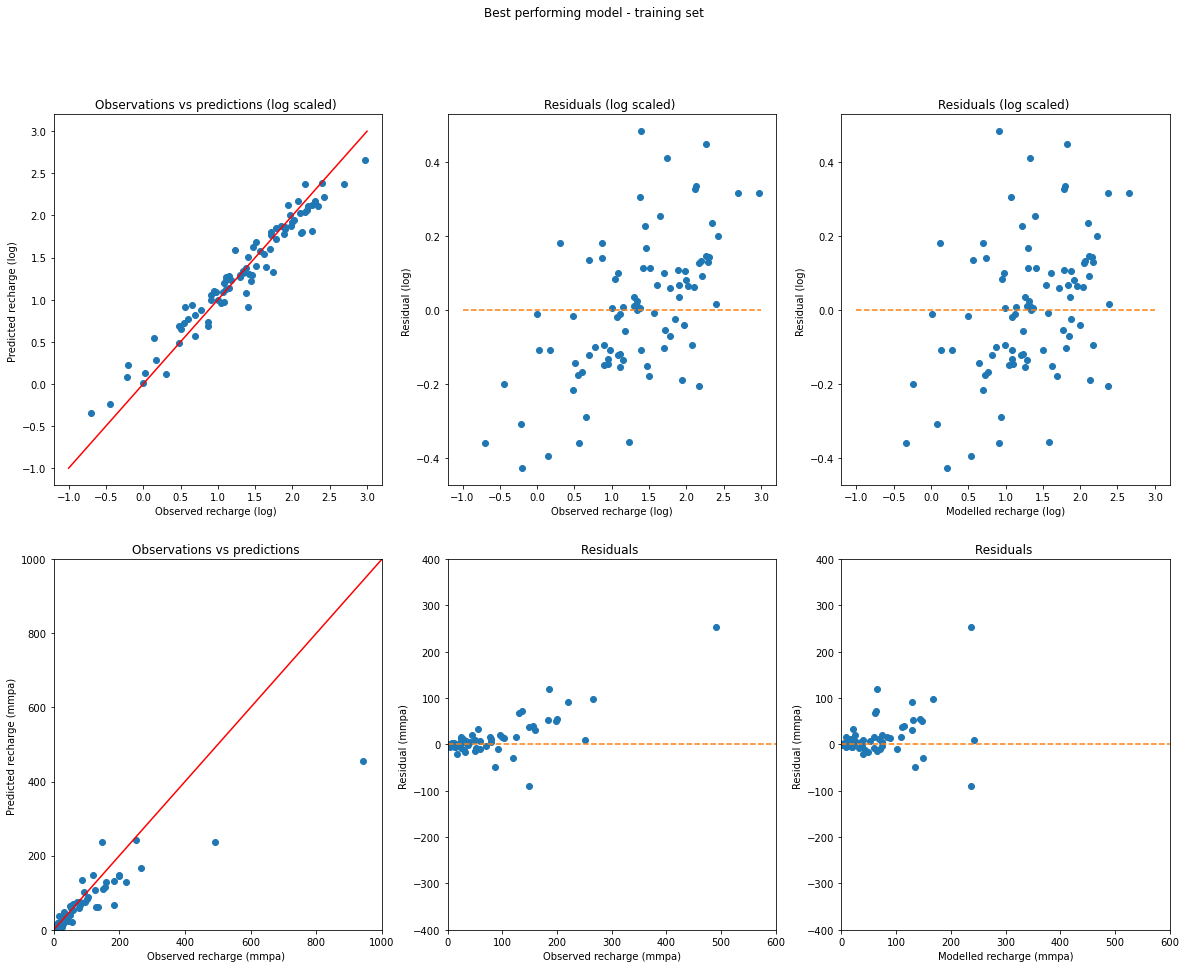

In [18]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Best performing model - training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels, best_train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels, 10**best_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_best.jpg')

In [19]:
# testing set metrics
print('=== Prediction of testing set - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels, best_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels, best_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_test_labels, best_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels, best_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels, best_predictions))
print('Max Error:', metrics.max_error(best_test_labels, best_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_test_labels, best_predictions))
print('R^2:', metrics.r2_score(best_test_labels, best_predictions))

=== Prediction of testing set - best performing model ===
Mean Absolute Error (MAE): 0.2512127630964418
Mean Squared Error (MSE): 0.10533043444093956
Root Mean Squared Error (RMSE): 0.32454650582149175
Mean Absolute Percentage Error (MAPE): 808150674922.5918
Explained Variance Score: 0.7919171604456222
Max Error: 1.0792075889037875
Median Absolute Error: 0.2049754057248232
R^2: 0.7900609737939468


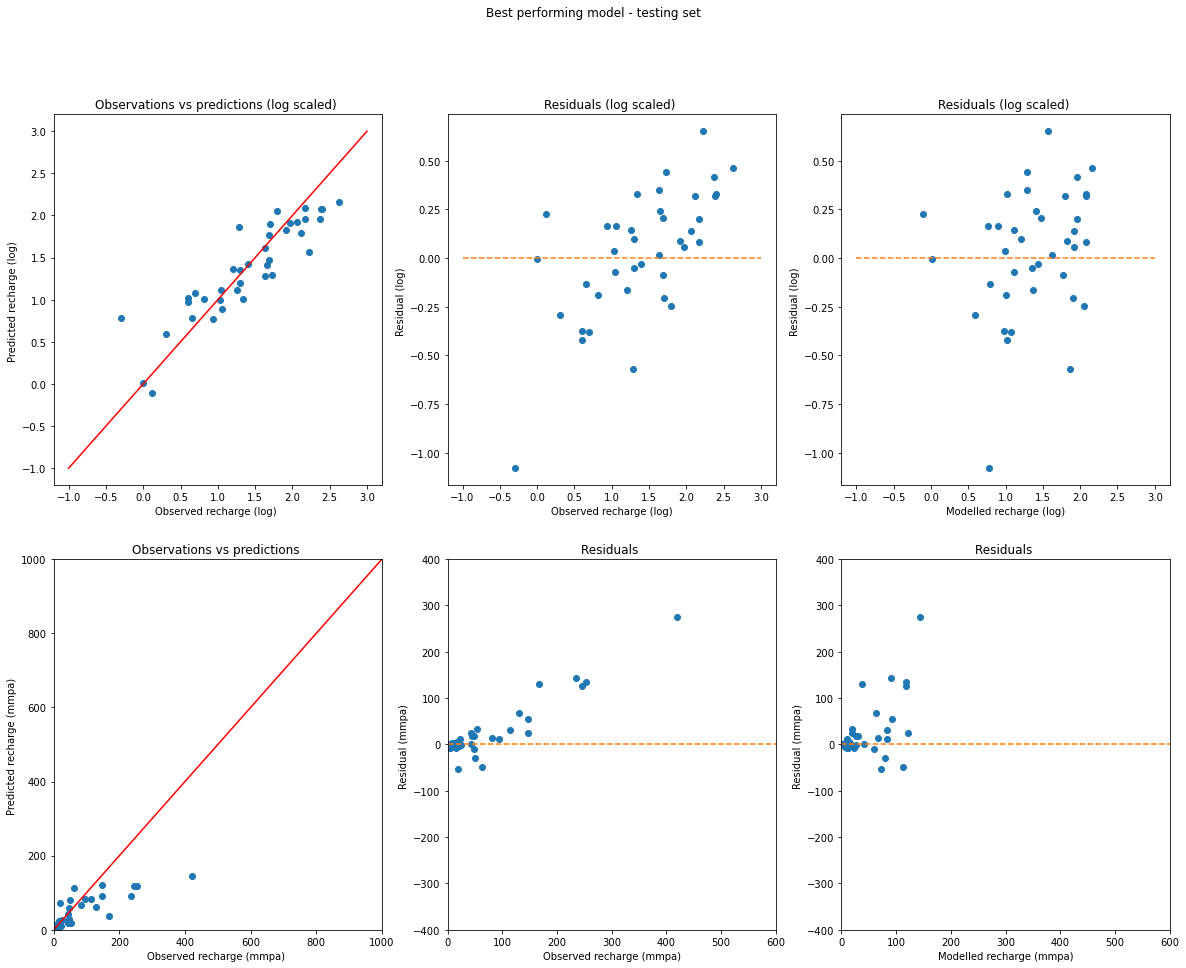

In [20]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Best performing model - testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels, best_predictions)
axs[
    0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels, best_test_labels - best_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions, best_test_labels - best_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels, 10**best_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_best.jpg')

### First run: statistics of the worst model

In [21]:
print(f'Out-of-bag R-2 score estimate: {worst_model.oob_score_:>5.3}')
print('Score: ', worst_model.score(worst_train_features, worst_train_labels))
print('Score: ', worst_model.score(worst_test_features, worst_test_labels))

Out-of-bag R-2 score estimate: 0.724
Score:  0.9564232211713829
Score:  0.28195214285634373


In [22]:
# training set metrics
print('=== Prediction of training set - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_train_labels, worst_train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_train_labels, worst_train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(worst_train_labels, worst_train_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_train_labels, worst_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(worst_train_labels, worst_train_predictions))
print('Max Error:', metrics.max_error(worst_train_labels, worst_train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(worst_train_labels, worst_train_predictions))
print('R^2:', metrics.r2_score(worst_train_labels, worst_train_predictions))

=== Prediction of training set - worst performing model ===
Mean Absolute Error (MAE): 0.12786262425318662
Mean Squared Error (MSE): 0.027861563231848782
Root Mean Squared Error (RMSE): 0.16691783377413205
Mean Absolute Percentage Error (MAPE): 2643202193190.2407
Explained Variance Score: 0.9564921328168908
Max Error: 0.5351511610940877
Median Absolute Error: 0.09068861084187929
R^2: 0.9564232211713829


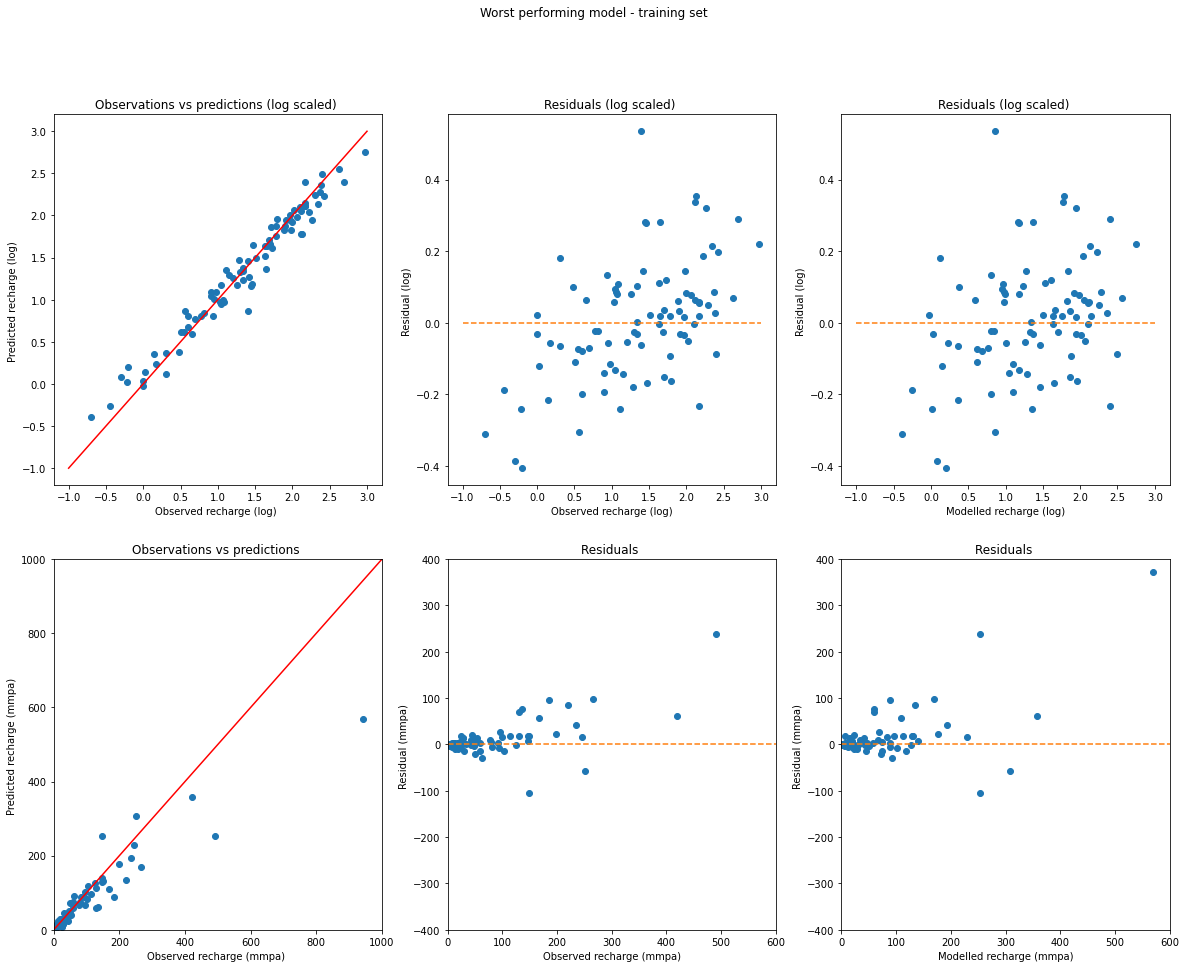

In [23]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Worst performing model - training set')
axs = axs.flatten()

axs[0].scatter(worst_train_labels, worst_train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_train_labels, worst_train_labels - worst_train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_train_predictions, worst_train_labels - worst_train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_train_labels, 10**worst_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_train_labels, 10**worst_train_labels - 10**worst_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_train_predictions, 10**worst_train_labels - 10**worst_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_worst.jpg')

In [24]:
# testing set metrics
print('=== Prediction of testing set - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_test_labels, worst_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_test_labels, worst_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(worst_test_labels, worst_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_test_labels, worst_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(worst_test_labels, worst_predictions))
print('Max Error:', metrics.max_error(worst_test_labels, worst_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(worst_test_labels, worst_predictions))
print('R^2:', metrics.r2_score(worst_test_labels, worst_predictions))

=== Prediction of testing set - worst performing model ===
Mean Absolute Error (MAE): 0.35057236994925284
Mean Squared Error (MSE): 0.2125707054106224
Root Mean Squared Error (RMSE): 0.46105390727183126
Mean Absolute Percentage Error (MAPE): 0.3432341569574331
Explained Variance Score: 0.28449617853630704
Max Error: 1.2128752017619804
Median Absolute Error: 0.28021458774983876
R^2: 0.28195214285634373


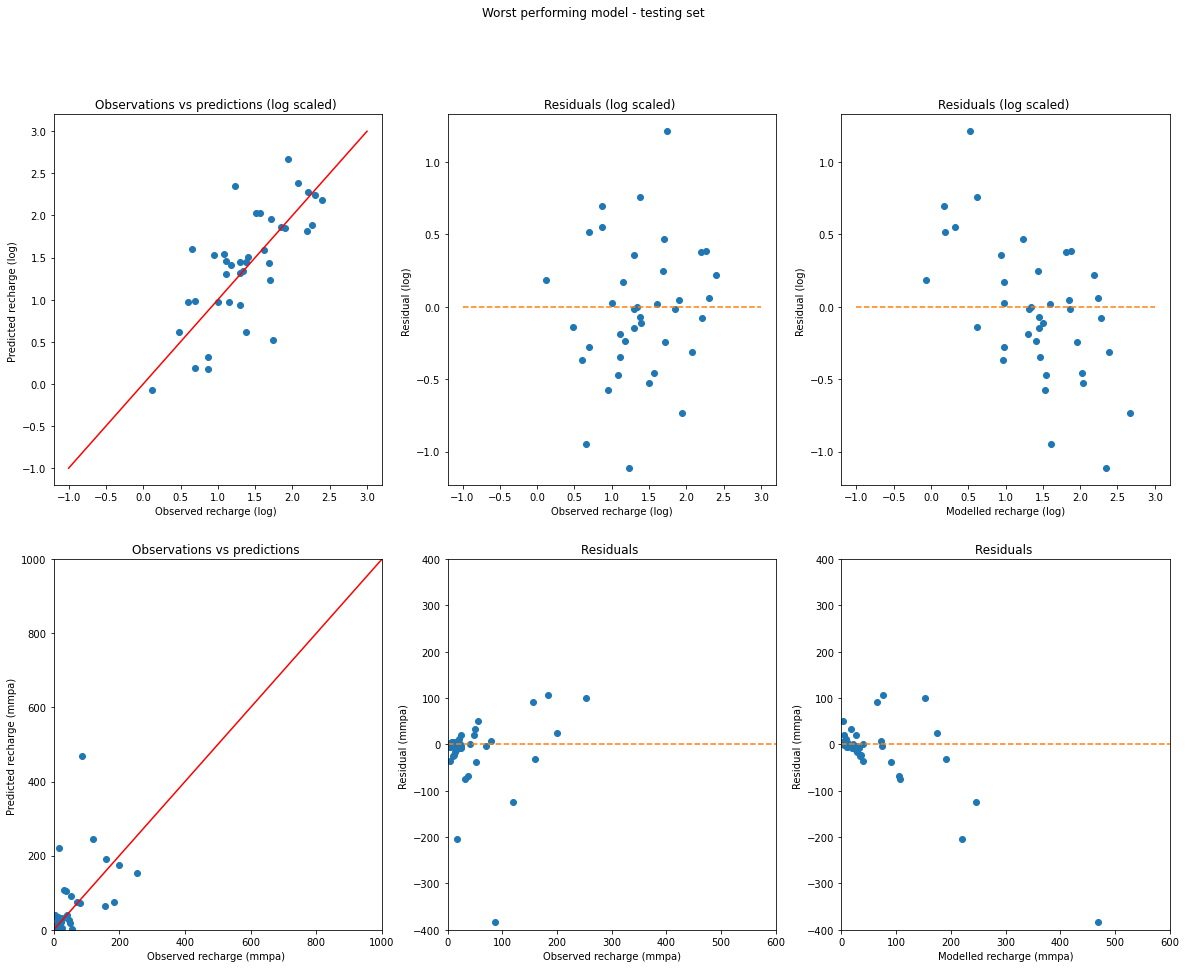

In [25]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Worst performing model - testing set')
axs = axs.flatten()

axs[0].scatter(worst_test_labels, worst_predictions)
axs[
    0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_test_labels, worst_test_labels - worst_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_predictions, worst_test_labels - worst_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_test_labels, 10**worst_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_test_labels, 10**worst_test_labels - 10**worst_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_predictions, 10**worst_test_labels - 10**worst_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_worst.jpg')

# Experiment 2: use important predictors only 

In [26]:
important_indices = [feature_list.index('LTA_P_mmpa'),
                     feature_list.index('LTA_PET_mm'),
                     feature_list.index('Aridity'), 
                     feature_list.index('NDVI'),
                     feature_list.index('SM10_m3m3')]

In [27]:
from sklearn.model_selection import RandomizedSearchCV

estimator = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [2000] * 10
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.33]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(features[:, important_indices], labels)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 0.33,
 'max_depth': 80}

In [28]:
# collect all importances, R2 and oob values to calculate the average over 100 models
importances = []
train_r2=[]
train_r2_untransf = []
test_r2_untransf = []
test_r2=[]
oobs=[]

# find the best model based on the lowest RMSE
best_model2 = None
best_r2 = 0
best_importances = None
best_train_features2, best_test_features2, best_train_labels2, best_test_labels2 = None, None, None, None
best_rmse = 300

# find the worst model based on the highest RMSE
worst_r2 = 100
worst_model2 = None
worst_train_features2, worst_test_features2, worst_train_labels2, worst_test_labels2 = None, None, None, None
worst_rmse = 0

#params = {'n_estimators': 2000}
params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'max_depth': 80,
 'bootstrap': True}

for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)    
    # Instantiate models with tunned hyperparameters
    rf = RandomForestRegressor(**params, oob_score=True)
      
    # Train the model on training data
    rf.fit(train_features[:,important_indices], train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features[:,important_indices])
    train_predictions = rf.predict(train_features[:, important_indices])
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    
    print(f'[{i}] Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = metrics.mean_squared_error(10**test_labels, 10**predictions, squared=False)
    print(f"current rmse {current_rmse}")
    if current_r2>best_r2:
        best_r2 = current_r2
        best_rmse = current_rmse
        best_model2 = rf
        best_importances = rf.feature_importances_
        best_train_features2, best_test_features2, best_train_labels2, best_test_labels2 = train_features, test_features, train_labels, test_labels
    if current_r2<worst_r2:
        worst_r2 = current_r2
        worst_rmse = current_rmse
        worst_model2 = rf
        worst_train_features2, worst_test_features2, worst_train_labels2, worst_test_labels2 = train_features, test_features, train_labels, test_labels
    importances.append(rf.feature_importances_)

[0] Out-of-bag score estimate: 0.594; Train R-2: 0.802, Test R-2:  0.77
current rmse 73.66343385679126
[1] Out-of-bag score estimate:  0.71; Train R-2: 0.852, Test R-2: 0.541
current rmse 78.37508686341695
[2] Out-of-bag score estimate: 0.654; Train R-2: 0.838, Test R-2: 0.712
current rmse 144.38768262942816
[3] Out-of-bag score estimate: 0.653; Train R-2: 0.832, Test R-2: 0.694
current rmse 47.36506497252251
[4] Out-of-bag score estimate: 0.668; Train R-2:  0.84, Test R-2: 0.646
current rmse 139.12045996760364
[5] Out-of-bag score estimate: 0.666; Train R-2: 0.835, Test R-2: 0.659
current rmse 69.69888163941435
[6] Out-of-bag score estimate: 0.716; Train R-2: 0.859, Test R-2:  0.54
current rmse 56.81048962107408
[7] Out-of-bag score estimate: 0.672; Train R-2:  0.84, Test R-2: 0.624
current rmse 148.54719445116172
[8] Out-of-bag score estimate: 0.757; Train R-2: 0.873, Test R-2: 0.423
current rmse 48.397226882790946
[9] Out-of-bag score estimate: 0.712; Train R-2:  0.86, Test R-2: 0.6

[79] Out-of-bag score estimate: 0.689; Train R-2: 0.849, Test R-2: 0.611
current rmse 64.40017081727694
[80] Out-of-bag score estimate:  0.66; Train R-2: 0.833, Test R-2: 0.626
current rmse 37.335216706964346
[81] Out-of-bag score estimate: 0.722; Train R-2: 0.866, Test R-2: 0.537
current rmse 81.52512362982445
[82] Out-of-bag score estimate: 0.632; Train R-2: 0.829, Test R-2: 0.675
current rmse 131.4634195582227
[83] Out-of-bag score estimate: 0.652; Train R-2: 0.833, Test R-2: 0.693
current rmse 49.38284461652415
[84] Out-of-bag score estimate:  0.71; Train R-2: 0.857, Test R-2: 0.542
current rmse 64.7418107811565
[85] Out-of-bag score estimate: 0.627; Train R-2: 0.816, Test R-2: 0.762
current rmse 52.57584537062212
[86] Out-of-bag score estimate:  0.63; Train R-2:  0.83, Test R-2: 0.729
current rmse 81.4351440691324
[87] Out-of-bag score estimate: 0.662; Train R-2: 0.841, Test R-2:  0.63
current rmse 57.85621236336314
[88] Out-of-bag score estimate: 0.687; Train R-2: 0.842, Test R-2

In [29]:
best_predictions2 = best_model2.predict(best_test_features2[:,important_indices])
# Use the forest's predict method on the training data
best_train_predictions2 = best_model2.predict(best_train_features2[:,important_indices])

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels2, 10**best_train_predictions2, squared=False)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {metrics.mean_squared_error(10**best_test_labels2, 10**best_predictions2, squared=False)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

+++ METRICS ON LOG-TRANSFORMED VALUES +++
Max R2 train: 0.8810561219977344
Min R2 train: 0.7903209396129286
Mean R2 train: 0.8372402481964132
Best RMSE train: 90.59721249965341

Max oob: 0.7568794436751911
Min oob: 0.5655207960118884
Mean oob: 0.6662797723693943

Max R2 test: 0.8737161876508133
Min R2 test: 0.3907709248306219
Mean R2 test: 0.6552851494180749
Best RMSE test: 48.937348288268396

+++ METRICS ON BACK TRANSFORMED VALUES +++
Max R2 train: 0.6918927152381388
Min R2 train: 0.42284343884068076
Mean R2 train: 0.5258652989862843

Max R2 test: 0.8292907985247329
Min R2 test: -0.4398984477291281
Mean R2 test: 0.3645570108992145


In [30]:
print("+++ Best model metrics +++")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model2.oob_score_:>5.3}')
print('Best R2 train: ', best_model2.score(best_train_features2[:, important_indices], best_train_labels2))
print(f'Best R2 test:  {best_model2.score(best_test_features2[:, important_indices], best_test_labels2)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels2, 10**best_train_predictions2, squared=False)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels2, 10**best_train_predictions2)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels2, 10**best_predictions2)}")

+++ Best model metrics +++
--- log transformed ---
Out-of-bag R-2 score estimate: 0.566
Best R2 train:  0.7903209396129286
Best R2 test:  0.8737161876508133

--- back transformed ---
Best RMSE train: 90.59721249965341
Best RMSE test: 48.937348288268396
Best R2 train: 0.49800989144495145
Best R2 test: 0.4968502789880438


In [31]:
worst_predictions2 = worst_model2.predict(worst_test_features2[:,important_indices])
# Use the forest's predict method on the training data
worst_train_predictions2 = worst_model2.predict(worst_train_features2[:,important_indices])
print("+++ Worst model metrics +++")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {worst_model2.oob_score_:>5.3}')
print('Worst R2 train: ', worst_model2.score(worst_train_features2[:, important_indices], worst_train_labels2))
print(f'Worst R2 test:  {worst_model2.score(worst_test_features2[:, important_indices], worst_test_labels2)}\n')
print("--- back transformed ---")
print(f'Worst RMSE train: {metrics.mean_squared_error(10**worst_train_labels2, 10**worst_train_predictions2, squared=False)}')
print(f"Worst RMSE test: {worst_rmse}")
print(f"Worst R2 train: {metrics.r2_score(10**worst_train_labels2, 10**worst_train_predictions2)}")
print(f"Worst R2 test: {metrics.r2_score(10**worst_test_labels2, 10**worst_predictions2)}")

+++ Worst model metrics +++
--- log transformed ---
Out-of-bag R-2 score estimate: 0.748
Worst R2 train:  0.8810561219977344
Worst R2 test:  0.3907709248306219

--- back transformed ---
Worst RMSE train: 83.59257174727365
Worst RMSE test: 67.2028945270094
Worst R2 train: 0.5514419306411443
Worst R2 test: 0.33617726930166025


In [32]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
feature_list = ['LTA_P_mmpa', 'LTA_PET_mm', 'Aridity', 'NDVI', 'DEM', 'SM10_m3m3', 'Landcover_cat']
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean feature importance
Variable: LTA_P_mmpa           Importance: 0.24
Variable: Aridity              Importance: 0.23
Variable: DEM                  Importance: 0.22
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.12


In [33]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Best performing model: feature importance
Variable: LTA_P_mmpa           Importance: 0.23
Variable: Aridity              Importance: 0.22
Variable: DEM                  Importance: 0.22
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.14


### Second run: statistics of the best model
Total dataset size: 134 samples <br>
Training set: 100 samples <br>
Testing set: 34 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- LTA NDVI
- DEM
- LTA soil moisture - 10cm (kgm-2)

In [34]:
print(f'Out-of-bag R-2 score estimate: {best_model2.oob_score_:>5.3}')
print('Score: ', best_model2.score(best_train_features2[:,important_indices], best_train_labels2))
print('Score: ', best_model2.score(best_test_features2[:,important_indices], best_test_labels2))

Out-of-bag R-2 score estimate: 0.566
Score:  0.7903209396129286
Score:  0.8737161876508133


In [35]:
print('=== Training set metrics - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_train_labels2, best_train_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_train_labels2, best_train_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_train_labels2, best_train_predictions2, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_train_labels2, best_train_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(best_train_labels2, best_train_predictions2))
print('R^2:', metrics.r2_score(best_train_labels2, best_train_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**best_train_labels2, 10**best_train_predictions2))

=== Training set metrics - best performing model ===
Mean Absolute Error (MAE): 0.2549359724921185
Mean Squared Error (MSE): 0.10935807028333905
Root Mean Squared Error (RMSE): 0.330693317566804
Mean Absolute Percentage Error (MAPE): 0.3241891014152571
Explained Variance Score: 0.7903235815304828
R^2: 0.7903209396129286
=== after back transformation ===
R^2: 0.49800989144495145


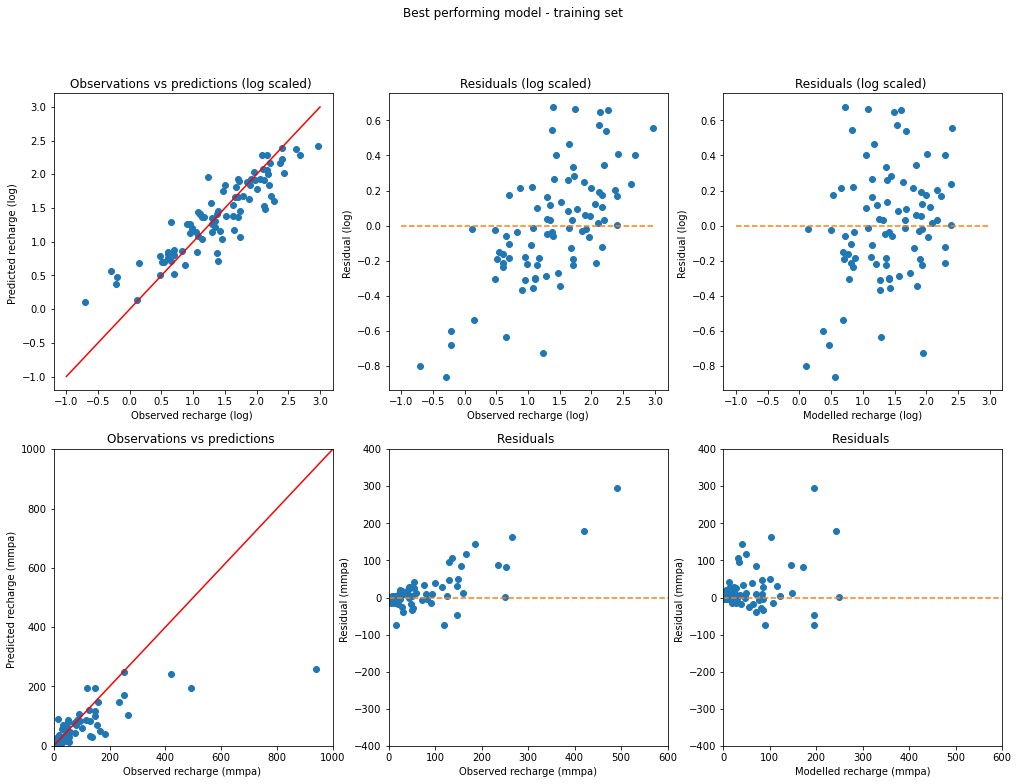

In [36]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Best performing model - training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels2, best_train_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels2, best_train_labels2 - best_train_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions2, best_train_labels2 - best_train_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels2, 10**best_train_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels2, 10**best_train_labels2 - 10**best_train_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions2, 10**best_train_labels2 - 10**best_train_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_2_best.jpg')

In [37]:
print('=== Testing set metrics - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels2, best_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels2, best_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_test_labels2, best_predictions2, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels2, best_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels2, best_predictions2))
print('Max Error:', metrics.max_error(best_test_labels2, best_predictions2))
print('R^2:', metrics.r2_score(best_test_labels2, best_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**best_test_labels2, 10**best_predictions2))

=== Testing set metrics - best performing model ===
Mean Absolute Error (MAE): 0.21355790248667497
Mean Squared Error (MSE): 0.06928194445987816
Root Mean Squared Error (RMSE): 0.26321463572506404
Mean Absolute Percentage Error (MAPE): 53856619525415.766
Explained Variance Score: 0.8738266470638629
Max Error: 0.7074468794847817
R^2: 0.8737161876508133
=== after back transformation ===
R^2: 0.4968502789880438


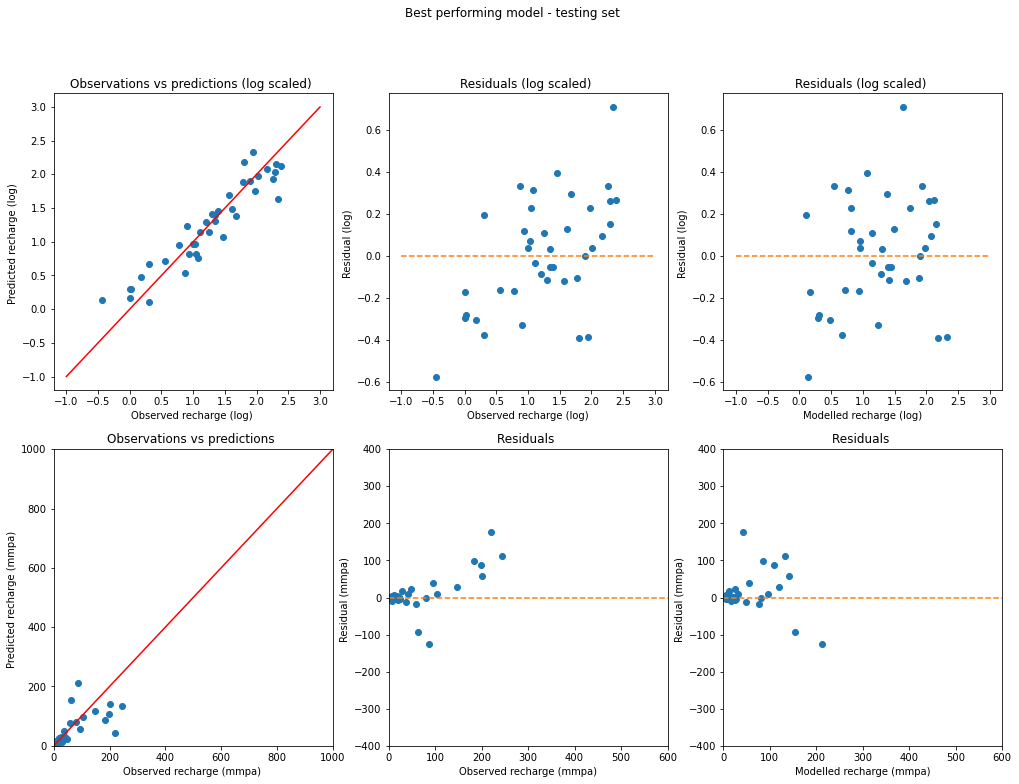

In [38]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Best performing model - testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels2, best_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels2, best_test_labels2 - best_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions2, best_test_labels2 - best_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels2, 10**best_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels2, 10**best_test_labels2 - 10**best_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions2, 10**best_test_labels2 - 10**best_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_2_best.jpg')

### Second run: statistics of the worst model


In [39]:
print(f'Out-of-bag R-2 score estimate: {worst_model2.oob_score_:>5.3}')
print('Score: ', worst_model2.score(worst_train_features2[:,important_indices], worst_train_labels2))
print('Score: ', worst_model2.score(worst_test_features2[:,important_indices], worst_test_labels2))

Out-of-bag R-2 score estimate: 0.748
Score:  0.8810561219977344
Score:  0.3907709248306219


In [40]:
print('=== Training set metrics - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_train_labels2, worst_train_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_train_labels2, worst_train_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(worst_train_labels2, worst_train_predictions2, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_train_labels2, worst_train_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(worst_train_labels2, worst_train_predictions2))
print('R^2:', metrics.r2_score(worst_train_labels2, worst_train_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**worst_train_labels2, 10**worst_train_predictions2))

=== Training set metrics - worst performing model ===
Mean Absolute Error (MAE): 0.19151939340948812
Mean Squared Error (MSE): 0.0696611126638342
Root Mean Squared Error (RMSE): 0.26393391722898024
Mean Absolute Percentage Error (MAPE): 4712983373678.251
Explained Variance Score: 0.8810629795239151
R^2: 0.8810561219977344
=== after back transformation ===
R^2: 0.5514419306411443


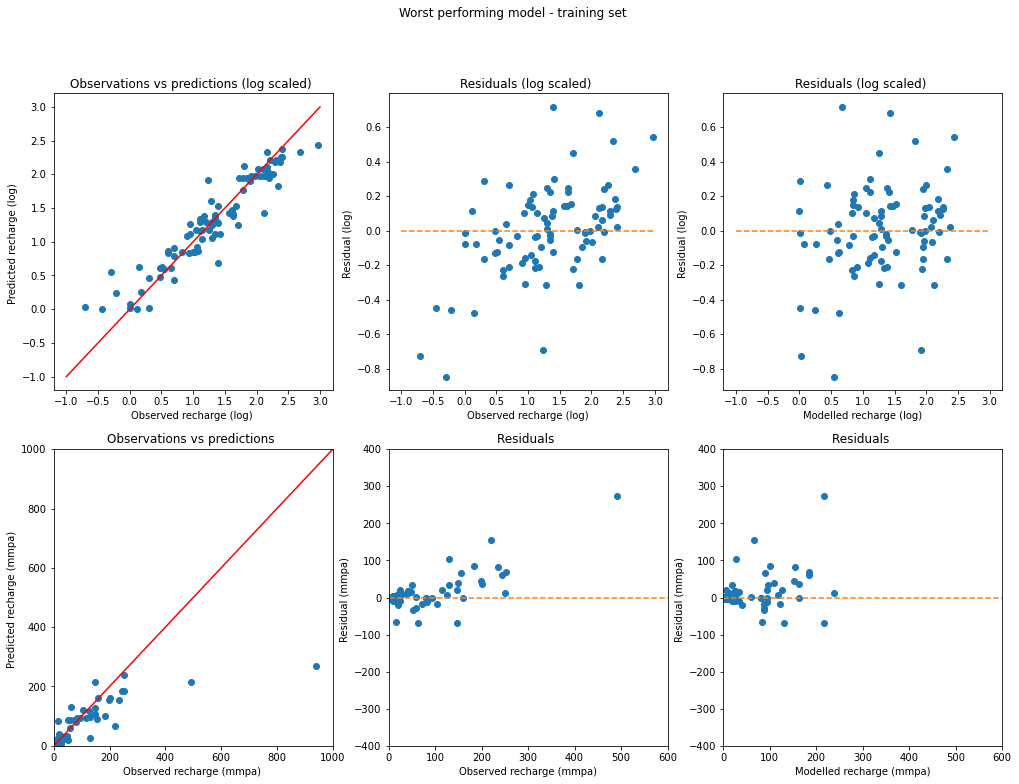

In [41]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Worst performing model - training set')
axs = axs.flatten()

axs[0].scatter(worst_train_labels2, worst_train_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_train_labels2, worst_train_labels2 - worst_train_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_train_predictions2, worst_train_labels2 - worst_train_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_train_labels2, 10**worst_train_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_train_labels2, 10**worst_train_labels2 - 10**worst_train_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_train_predictions2, 10**worst_train_labels2 - 10**worst_train_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_2_worst.jpg')

In [42]:
print('=== Testing set metrics - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_test_labels2, worst_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_test_labels2, worst_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(worst_test_labels2, worst_predictions2, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_test_labels2, worst_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(worst_test_labels2, worst_predictions2))
print('Max Error:', metrics.max_error(worst_test_labels2, worst_predictions2))
print('R^2:', metrics.r2_score(worst_test_labels2, worst_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**worst_test_labels2, 10**worst_predictions2))

=== Testing set metrics - worst performing model ===
Mean Absolute Error (MAE): 0.40571154984793434
Mean Squared Error (MSE): 0.24559417970909883
Root Mean Squared Error (RMSE): 0.4955745955041469
Mean Absolute Percentage Error (MAPE): 0.6256783382186928
Explained Variance Score: 0.42790924381798523
Max Error: 1.0239954576801191
R^2: 0.3907709248306219
=== after back transformation ===
R^2: 0.33617726930166025


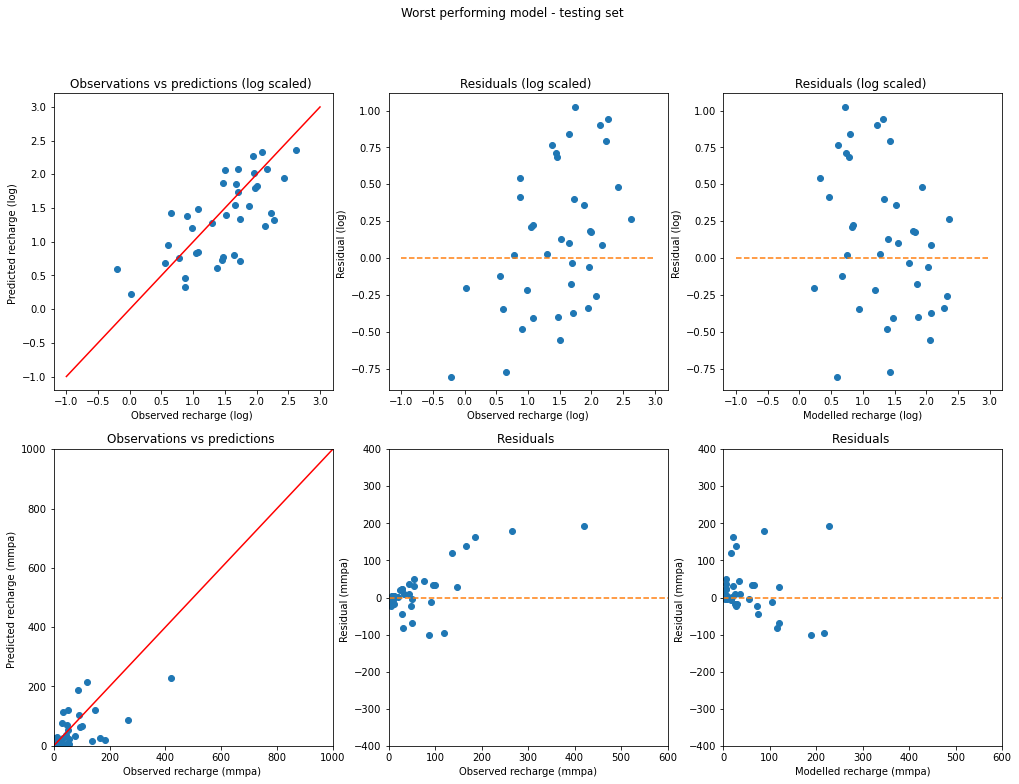

In [43]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Worst performing model - testing set')
axs = axs.flatten()

axs[0].scatter(worst_test_labels2, worst_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_test_labels2, worst_test_labels2 - worst_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_predictions2, worst_test_labels2 - worst_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_test_labels2, 10**worst_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_test_labels2, 10**worst_test_labels2 - 10**worst_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_predictions2, 10**worst_test_labels2 - 10**worst_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_2_worst.jpg')